###Importing Libraries

In [ ]:
#libraries

import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,roc_auc_score, roc_curve,roc_curve, auc
from collections import Counter
from math import log

import math
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold,cross_validate
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn import ensemble
from sklearn.metrics import f1_score,precision_score,recall_score,make_scorer,accuracy_score
from sklearn.preprocessing import PowerTransformer
from random import randrange, uniform
from scipy.stats import chi2_contingency

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

%matplotlib inline
warnings.filterwarnings('ignore')

###Getting data

In [ ]:
!pip install -q kaggle
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
#Moving authentication file to required location
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c santander-customer-transaction-prediction

  0% 0.00/462k [00:00<?, ?B/s]
100% 462k/462k [00:00<00:00, 67.9MB/s]
 94% 117M/125M [00:01<00:00, 64.1MB/s]
100% 125M/125M [00:01<00:00, 85.9MB/s]
 95% 119M/125M [00:01<00:00, 120MB/s] 
100% 125M/125M [00:01<00:00, 95.7MB/s]


In [ ]:
# Import the test and train datasets into pandas dataframe
train = pd.read_csv('train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
test = pd.read_csv('test.csv.zip', compression='zip', header=0, sep=',', quotechar='"')

###Feature Engineering

In [ ]:
#removing duplicates
features = train.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
  values = train[feature].value_counts()
  unique_max_train.append([feature, values.max(), values.idxmax()])
  values = test[feature].value_counts()
  unique_max_test.append([feature, values.max(), values.idxmax()])

In [ ]:
#Adding new feature columns
idx = features = train.columns.values[2:202]
for df in [test, train]:
  df['sum'] = df[idx].sum(axis=1)  
  df['min'] = df[idx].min(axis=1)
  df['max'] = df[idx].max(axis=1)
  df['mean'] = df[idx].mean(axis=1)
  df['std'] = df[idx].std(axis=1)
  df['skew'] = df[idx].skew(axis=1)
  df['kurt'] = df[idx].kurtosis(axis=1)
  df['med'] = df[idx].median(axis=1)

In [ ]:
train.drop(['kurt'],axis=1,inplace=True)

In [ ]:
train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [ ]:
test.drop(['kurt','ID_code'],axis=1,inplace=True)

##Models

###LR

####Data transformation to optimize performance of LR

In [ ]:
trans =pd.read_csv('train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')

In [ ]:
for i in range(2,202):
  q75, q25 = np.percentile(trans.iloc[:,i], [75 ,25])
  iqr = q75 - q25
  min = q25 - (iqr*1.5)
  max = q75 + (iqr*1.5)
  trans = trans.drop(trans[trans.iloc[:,i] < min].index)
  trans = trans.drop(trans[trans.iloc[:,i] > max].index)

In [ ]:
trans.shape

(175073, 202)

In [ ]:
trans.to_csv("outlier values.csv")
trans = trans.drop(trans.columns[0], axis = 1)

In [ ]:
#Creating training and testing data
from  sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(trans.drop('target',axis=1),
                                                    trans['target'], test_size=0.30, 
                                                    random_state=101)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(122551, 200)
(52522, 200)


In [ ]:
x_train

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
84999,9.9026,-7.5640,12.3459,9.0341,13.3910,11.1034,5.7327,18.8606,-3.6940,5.6801,3.1393,8.6526,14.3023,8.8697,4.8441,15.1137,4.7005,-12.6175,10.1042,24.5248,6.5197,14.5162,5.5741,2.9131,11.7110,13.5125,-4.7029,0.6761,6.3576,4.5403,-2.6809,8.3065,4.2618,15.9416,12.0820,-7.1038,0.5958,6.6221,4.8983,-3.4409,...,15.8751,5.7553,5.5322,9.9948,-10.3076,18.7472,2.5191,-4.2438,5.3978,6.1120,-2.4628,-7.7764,11.9537,8.5507,26.9794,10.4426,-5.9211,10.4951,11.5827,6.2951,-10.0580,10.7789,1.3776,10.2420,12.6699,-6.6096,3.8256,7.2281,19.8045,1.7976,6.4452,3.3673,3.5469,10.0076,20.8119,0.2316,1.9427,8.4721,13.9658,5.9969
93996,13.4418,6.2457,7.8581,9.5325,13.1430,-16.4925,4.0794,16.4086,-1.1415,7.6592,-7.0183,-6.5720,13.9802,7.9693,9.4816,14.8914,8.6335,-8.4533,21.0977,1.3263,13.5994,20.1538,7.6186,1.7935,9.5797,14.0488,0.4224,1.8218,5.4236,11.7326,-13.3003,12.5307,-3.3173,17.4184,11.8115,9.8837,3.6025,9.1948,10.3110,-0.4302,...,19.8547,5.7506,4.8031,10.2954,-5.9347,24.7141,2.8792,0.8735,3.5965,5.2029,5.9075,2.2688,6.5226,1.1604,18.9406,9.7560,3.9454,9.2524,-0.7693,0.8680,-4.5927,12.9026,11.0559,4.9745,21.5223,-9.0039,14.1025,-23.2112,18.2243,0.1992,4.6255,5.8306,2.3304,4.8247,24.0218,0.2577,-1.3856,7.2253,10.9538,14.0932
54122,7.6075,0.7561,13.7921,7.4513,11.2389,-8.7332,4.7076,12.4610,2.2417,9.3714,-0.7088,3.6898,13.9719,16.0522,7.1361,14.3634,9.9513,3.9464,19.3907,8.8972,17.0848,20.0007,7.8080,3.8038,4.5732,13.7702,-1.3371,-0.2568,5.8212,3.5361,-18.6314,13.1694,-5.3483,18.2560,11.8110,-3.9142,0.4147,8.6197,14.0247,-1.3032,...,25.1042,5.9750,4.3168,12.4982,-8.3991,16.2044,2.9701,-3.7315,2.4977,5.2744,4.5493,7.8027,43.2730,-6.6620,10.7121,11.9272,-11.6274,9.7134,-3.3484,4.7452,-0.0890,10.8046,-8.0025,11.4882,19.4104,-7.2951,11.5741,-16.7702,14.0226,-0.9753,8.8718,9.2503,1.8047,-0.5987,14.7692,-2.6407,2.2857,10.4102,16.7069,-18.3792
194870,14.8133,-2.0084,15.3357,6.6154,11.9056,-6.0030,5.6675,21.3706,-1.8567,7.1440,-3.5249,11.0165,14.1915,6.4745,8.9752,14.3303,7.4362,-18.9389,6.9760,21.3057,20.5719,30.4256,1.2375,2.4761,13.8961,13.7266,-15.2468,-4.1472,5.6250,9.0027,-20.1597,11.1914,-3.8879,15.6952,11.6586,-3.5848,6.5131,6.9606,13.7591,-2.6622,...,33.4621,5.4211,5.1119,2.2219,-8.3627,20.8078,2.8072,-6.0662,3.9836,6.1503,-2.7752,1.1231,20.1442,9.8275,25.1219,8.6574,-14.3510,10.5844,-8.0290,0.9043,0.6905,11.5419,12.4725,14.4758,18.1290,-0.3633,7.2973,4.8175,13.7715,0.7977,-4.9106,3.7083,1.5973,-1.7463,13.5933,-0.3821,4.6887,9.2920,17.7150,5.0699
161114,9.5972,6.5295,7.7517,5.7622,10.5638,-6.6728,5.9140,24.5216,-0.5750,6.0351,2.8306,-5.6323,14.1774,14.1566,7.7838,14.7811,8.0105,-13.5393,4.9504,12.7761,9.9073,16.1102,4.8084,2.5610,13.3306,13.2664,-6.7430,-3.5629,4.3634,3.5753,5.2232,11.9624,-0.1162,15.7942,12.2310,12.9526,2.5245,6.0400,6.9010,-1.1859,...,33.0458,5.3549,6.4821,13.7168,-5.7053,22.8150,2.6309,-6.7840,1.8451,5.6257,3.7820,-1.2305,19.0181,1.4113,21.3454,13.1207,-5.7764,12.0006,2.9632,1.3388,0.1886,9.8526,1.3268,7.8837,21.8727,-12.1860,2.6810,-14.4103,17.7982,1.5196,1.6723,12.0580,2.4178,0.9954,20.9480,0.0820,-7.4066,8.3506,13.9636,8.4823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

####Modelling

Printing parameter Data and Corresponding Log value
   Parameter value  Corresponding Log Value
0           0.0001                -4.000000
1           0.0010                -3.000000
2           0.0100                -2.000000
3           0.1000                -1.000000
4           1.0000                 0.000000
5           5.0000                 0.698970
6          10.0000                 1.000000
7          20.0000                 1.301030
8          30.0000                 1.477121
9          40.0000                 1.602060


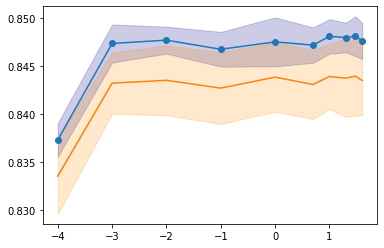

In [ ]:
#Using RandomCV and finding the best Logistic regression model

lr = LogisticRegression()
params = [0.0001,0.001,0.01,0.1,1,5,10,20,30,40]

log_data = [math.log10(x) for x in params]

print("Printing parameter Data and Corresponding Log value")
data={'Parameter value':params,'Corresponding Log Value':log_data}
param=pd.DataFrame(data)
print("="*100)
print(param)

parameters = {"C":[0.0001,0.001,0.01,0.1,1,5,10,20,30,40], "penalty":["l2"], 'solver' : ['liblinear']}
clf_lr = RandomizedSearchCV(lr, parameters, cv=3, scoring='roc_auc', return_train_score=True, n_jobs=-1)
clf_lr.fit(x_train, y_train)

auc_train= clf_lr.cv_results_['mean_train_score']
std_auc_train= clf_lr.cv_results_['std_train_score']
cv_auc = clf_lr.cv_results_['mean_test_score'] 
cv_auc_std= clf_lr.cv_results_['std_test_score']

plt.plot(log_data, auc_train, label='Train AUC')
plt.gca().fill_between(log_data,auc_train - std_auc_train,auc_train + std_auc_train,alpha=0.2,color='darkblue')

plt.plot(log_data, cv_auc, label='CV AUC')
plt.gca().fill_between(log_data,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(log_data, auc_train, label='Train AUC points')

In [ ]:
#Best LR classifier
clf.best_estimator_

LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
def model_predict(clf, data):
  y_data_pred = []
  y_data_pred.extend(clf.predict_proba(data[:])[:,1])
  
  return y_data_pred

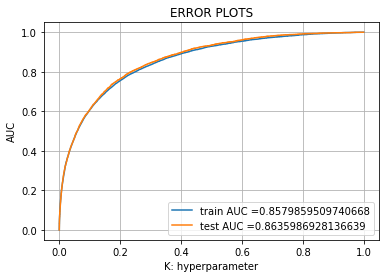

In [ ]:
#Checking Model Performance

lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, max_iter=100,
                   n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
lr.fit(x_train, y_train)

y_train_pred = model_predict(lr, x_train)    
y_test_pred = model_predict(lr, x_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [ ]:
#Final Submission DF fro LR
test_lr = pd.read_csv('test.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
ab = test_lr.drop("ID_code" ,axis=1)
predictions_test = lr.predict(ab)
df_lr = pd.DataFrame({"ID_code" :test_lr['ID_code'] ,"target": predictions_test})
df_lr.to_csv('logisticmodelpred.csv',index=False)
df_lr.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


###NB

In [ ]:
#Finding best model for Naive Bayes
nb_classifier = GaussianNB()
params_NB = {'var_smoothing': np.<a onclick="parent.postMessage({'referent':'.numpy.logspace'}, '*')">logspace(0,-9, num=100)}


for i in range(5):
  X_train = train_X
  y_target = train_y

  inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
  outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    
  nbc = GridSearchCV(estimator=nb_classifier, param_grid=params_NB, cv=inner_cv,refit=True)
  nbc.fit(X_train,y_target)

In [ ]:
neigh.get_params

<bound method BaseEstimator.get_params of GaussianNB(priors=None, var_smoothing=1e-09)>

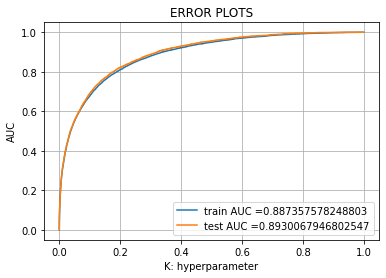

In [ ]:
#Naive Baies model performance
neigh = GaussianNB()
neigh.fit(x_train, y_train)

y_train_pred = model_predict(neigh, x_train)    
y_test_pred = model_predict(neigh, x_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [ ]:
#Final submission Df
test_nb = pd.read_csv('test.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
test_nb1 = test_nb.drop("ID_code" ,axis=1)

predictions_test = neigh.predict(test_nb1)
df_nb = pd.DataFrame({"ID_code" :test_nb['ID_code'] ,"target": predictions_test})
df_nb.to_csv('NBpred.csv',index=False)
df_nb.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


###RFC

In [ ]:
#Random Forest Classifier
rfc = RandomForestClassifier()


x_train = train_X
y_target = train_y
n_estimators=[10,50,100,200]
max_depth=[1, 5, 10, 50]

log_max_depth = [math.log10(x) for x in max_depth]
log_n_estimators=[math.log10(x) for x in n_estimators]

print("Printing parameter Data and Corresponding Log value for Estimators")
data={'Parameter value':n_estimators,'Corresponding Log Value':log_n_estimators}
param=pd.DataFrame(data)
print("="*100)
print(param)

#GridSearchCV
param_grid = {'n_estimators':n_estimators, 
              'max_depth':max_depth,
              'n_jobs':[-1],
              'max_features' :['auto', 'sqrt', 'log2'],
              'class_weight' : ['balanced','balanced_subsample','None']}
cl_rfc = GridSearchCV(rfc, param_grid, cv=3, scoring='roc_auc', return_train_score=True,n_jobs=-1)
cl_rfc.fit(x_train, y_target)

#Performance
train_auc= cl_rfc.cv_results_['mean_train_score']
train_auc_std= cl_rfc.cv_results_['std_train_score']
cv_auc = cl_rfc.cv_results_['mean_test_score'] 
cv_auc_std= cl_rfc.cv_results_['std_test_score']

Printing parameter Data and Corresponding Log value for Estimators
   Parameter value  Corresponding Log Value
0               10                  1.00000
1               50                  1.69897
2              100                  2.00000
3              200                  2.30103


In [ ]:
#Best performing parameters
cl_rfc.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

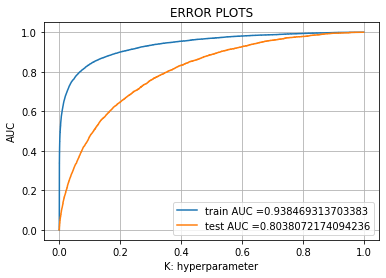

In [ ]:
#Plotting performance of RFC

rfc = RandomForestClassifier(n_estimators=100,max_depth=10,class_weight='balanced')
rfc.fit(x_train, y_train)

y_train_pred = model_predict(rfc, x_train)   
y_test_pred = model_predict(rfc, x_test)


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [ ]:
#Creating final submission DF for RFC
test_rfc = pd.read_csv('test.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
test_rfc = test_rfc.drop("ID_code" ,axis=1)

predictions_rfc = rfc.predict(test_rfc)
df_rfc = pd.DataFrame({"ID_code" :test_lr['ID_code'] ,"target": predictions_rfc})
df_rfc.to_csv('RandomForestPrediction.csv',index=False)
df_rfc.head()

,ID_code,target
0,test_0,1
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


###XG Boost

In [ ]:
scoring = 'roc_auc'
NUM_TRIALS = 5
xg_scores = np.zeros(NUM_TRIALS)
train_X.shape

(200000, 400)

In [ ]:
xg_grid = {'n_estimators': np.asarray([500,750,860,710,1000]),
           'max_depth':np.asarray([15,20,35]),
           'min_samples_split': [2], 
           'learning_rate': [0.01],
           'n_jobs':[-1],
           'nthread':[-1],
           'scale_pos_weight':[1],
           'colsample_bytree' :[0.5],
           'subsample' : [0.7,0.9],
           'objective':['binary:logistic'], 
           'reg_alpha' :[ 0.2,0.5,1.1,1.3],
           'max_depth':[6], 
           'gamma':[0], 'random_state':[42],
           'tree_method':[ "gpu_hist"]
           }
xg = xgb.XGBClassifier()


for i in range(5):
    X_train = train_X
    y_target = train_y

    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    
    xg_reg = GridSearchCV(estimator=xg, param_grid=xg_grid, cv=inner_cv,refit=True,scoring=scoring)
    xg_reg.fit(X_train,y_target)
    

In [ ]:
xg_reg.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, min_samples_split=2, missing=None,
              n_estimators=1000, n_jobs=-1, nthread=-1,
              objective='binary:logistic', random_state=42, reg_alpha=0.2,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.7, tree_method='gpu_hist', verbosity=1)

In [ ]:
xg_reg.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=KFold(n_splits=4, random_state=4, shuffle=True),
             error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     rand...
                         'learning_rate': [0.01], 'max_depth': [6],
                         'min_samples_split': [2],
                         'n_estimators': array([ 500,  750,  860,  710, 1000]),
                         'n_jobs': [-1], 'nthread': [-1],
                         'objective': ['bin

In [ ]:
#Creating final submission Df
test1 = pd.read_csv('test.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
sub_df =  pd.DataFrame({"ID_code":test1["ID_code"].values})
predictions = xg_reg.predict(test_X)
sub_df["target"] = predictions
sub_df.to_csv("xg.csv", index=False)